In [1]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#GCP
import io
from io import BytesIO
#
from matplotlib import colors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTENC
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings


from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

warnings.filterwarnings('ignore')

C:\Users\Makis\AppData\Local\Temp\ipykernel_21004\2250321789.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Function to get a table summarizing input dataframe's dtype, no of unique values and missing values for each feature
def getDataSummary(input_df):
    count_unique_values = []
    category_features = []
    num_features = []

    for column in input_df:
        # Count unique values for each column
        cnt_unique_values = len(input_df[column].unique())
        count_unique_values.append(cnt_unique_values)
        if input_df[column].dtype == 'O':
            category_features.append(column)
        else:
            num_features.append(column)

    # Summarize column attributes using a dataframe
    data_info = pd.DataFrame()
    data_info['data_type'] = input_df.dtypes

    # Add details
    data_info['count_unique_values'] = count_unique_values
    data_info['count_null'] = input_df.isna().sum()
    return data_info, category_features, num_features


# Data Profiling

In [3]:
# df = pd.read_csv("./AppCustomerReviews.csv")
df = pd.read_csv("./v5.csv")
df.head(10)


,Customer ID,Name,Location,Gender,Age,Access Frequency,Preferred Map Type,Person with Disability,Rating,Review
0,1,Alice,Toronto,M,25,daily,default-2d,no,5,Easy to use and very informative
1,2,Bob,Toronto,M,32,daily,default-2d,yes,2,Issues with handicap parking space availability
2,3,Charlie,Montreal,F,61,monthly,default-2d,no,2,Map symbols complex
3,4,David,Winnipeg,F,42,weekly,default-2d,yes,5,I like it's simplicity in finding parking
4,5,Emma,Vancouver,M,61,weekly,default-2d,no,2,It is easy to use
5,6,Alice,Montreal,M,19,weekly,default-2d,no,4,It is easy to use
6,7,Bob,Toronto,F,29,daily,default-2d,yes,2,not up-to-date due to construction
7,8,Charlie,Montreal,M,46,weekly,default-2d,yes,2,confusing symbols
8,9,David,Calgary,F,39,daily,3d,yes,5,It's simple to operate
9,10,Emma,Calgary,M,63,monthly,default-2d,no,2,It is easy to use


In [4]:
# Set Customer ID as index
# df.set_index('Customer ID', inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Customer ID             2936 non-null   int64 
 1   Name                    2936 non-null   object
 2   Location                2936 non-null   object
 3   Gender                  2936 non-null   object
 4   Age                     2936 non-null   int64 
 5   Access Frequency        2936 non-null   object
 6   Preferred Map Type      2936 non-null   object
 7   Person with Disability  2936 non-null   object
 8   Rating                  2936 non-null   int64 
 9   Review                  2936 non-null   object
dtypes: int64(3), object(7)
memory usage: 229.5+ KB


In [6]:
# df[df['Cluster'].isnull()]

In [7]:
df[df.duplicated('Customer ID')]

,Customer ID,Name,Location,Gender,Age,Access Frequency,Preferred Map Type,Person with Disability,Rating,Review


In [8]:
data_info, categorical_features, numerical_features = getDataSummary(df)

In [9]:
df['Preferred Map Type'].value_counts()

Preferred Map Type
default-2d    1840
3d             552
satellite      368
terrain        176
Name: count, dtype: int64

In [10]:
df.describe()

,Customer ID,Age,Rating
count,2936.00000,2936.000000,2936.000000
mean,1468.50000,39.540872,3.212534
std,847.69452,13.657443,1.560520
min,1.00000,15.000000,1.000000
25%,734.75000,28.000000,2.000000
50%,1468.50000,36.000000,4.000000
75%,2202.25000,52.000000,5.000000
max,2936.00000,67.000000,5.000000


In [11]:
# Combine the review columns into just 1 column
# df['Review'] = np.where(df['ReviewPart2'].notnull(), df['Review'] + df['ReviewPart2'], df['Review'])

In [12]:
# For our model data to be trained drop the unnecessary extra column and the Name column that does not contirbute to analysis
model_df= df.drop(['Name', 'Customer ID'],axis=1)

In [13]:
model_df.head(3)

,Location,Gender,Age,Access Frequency,Preferred Map Type,Person with Disability,Rating,Review
0,Toronto,M,25,daily,default-2d,no,5,Easy to use and very informative
1,Toronto,M,32,daily,default-2d,yes,2,Issues with handicap parking space availability
2,Montreal,F,61,monthly,default-2d,no,2,Map symbols complex


In [14]:
data_info, categorical_features, numerical_features = getDataSummary(model_df)

# EDA

In [15]:
sns.set_style("ticks")
sns.set_palette('pastel')

## Univariate Analysis

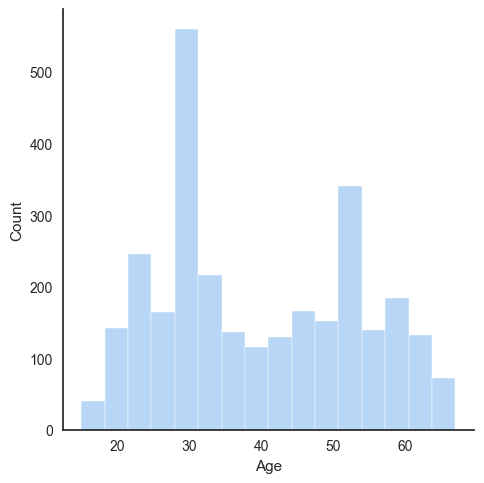

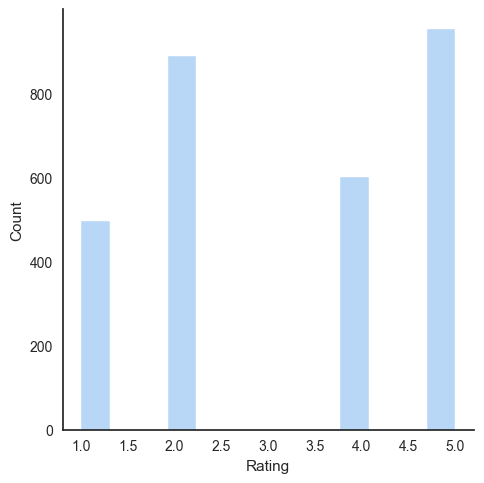

In [16]:
# Check the distribution of numerical features
for feature in numerical_features:
    sns.displot(model_df, x=feature)


In [17]:
df_categorical = model_df.loc[:, ((model_df.columns != 'Name') & (model_df.columns != 'Review'))]

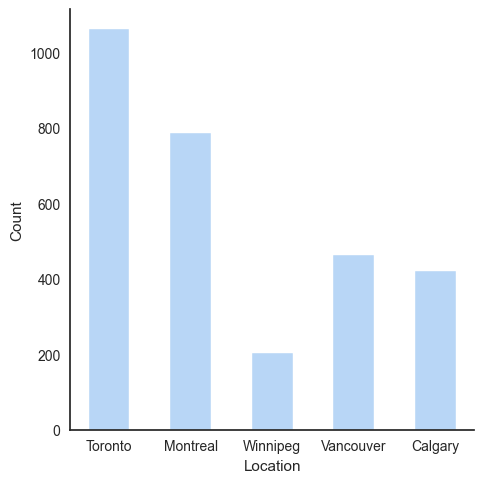

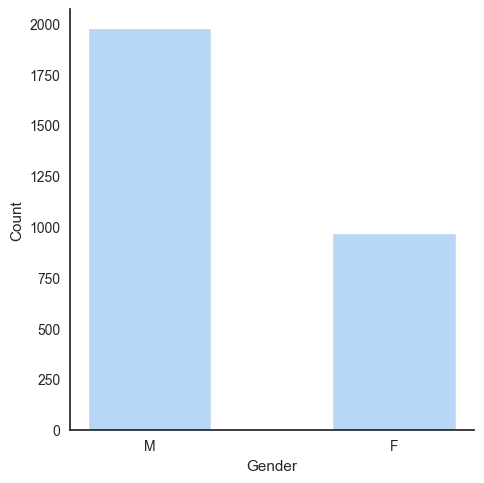

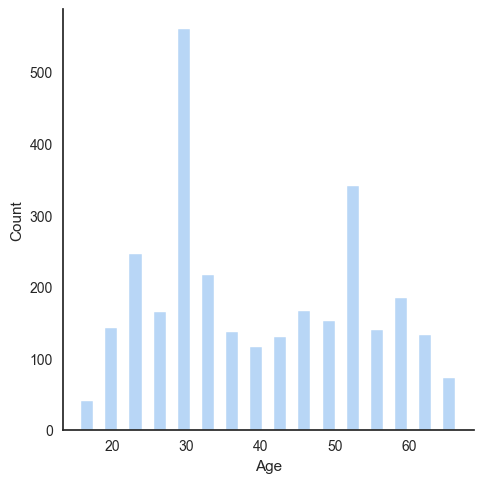

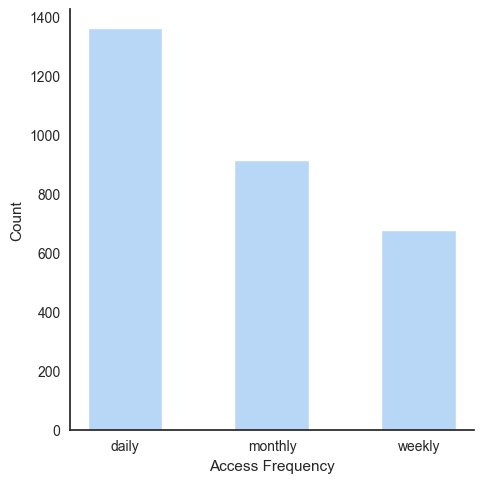

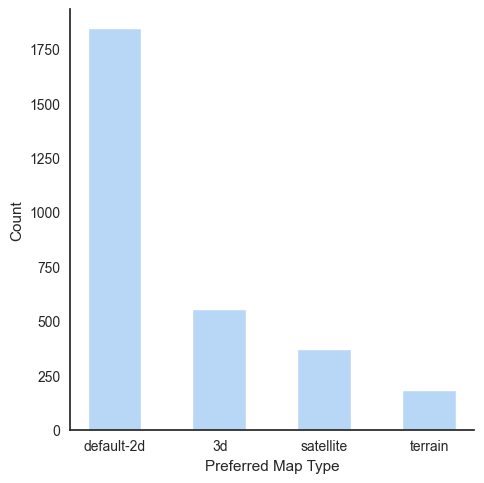

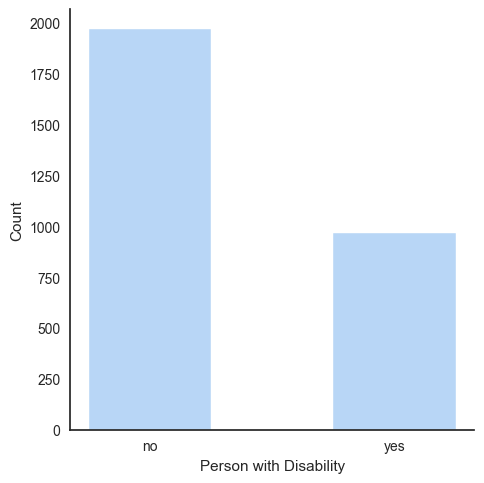

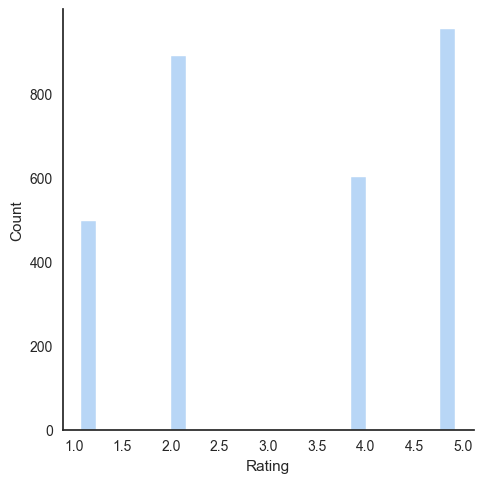

In [18]:
# Check the distribution of numerical features
for feature in df_categorical:
    sns.displot(df_categorical, x=feature, shrink=.5)

Boxplot

<Axes: xlabel='Age'>

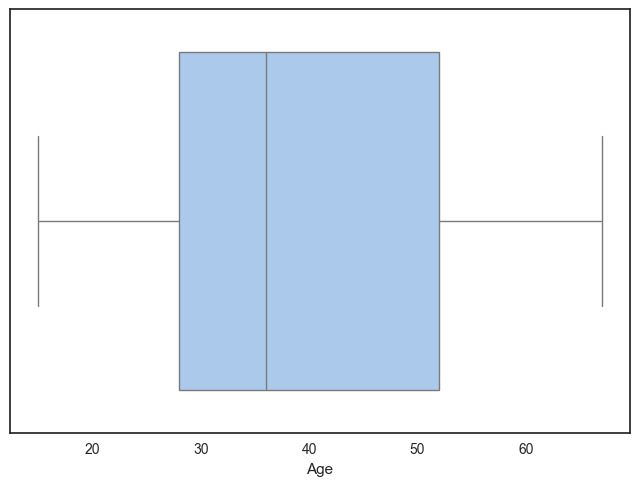

In [19]:
# Check the distribution of numerical features
sns.boxplot(x=model_df['Age'])

<Axes: xlabel='Rating'>

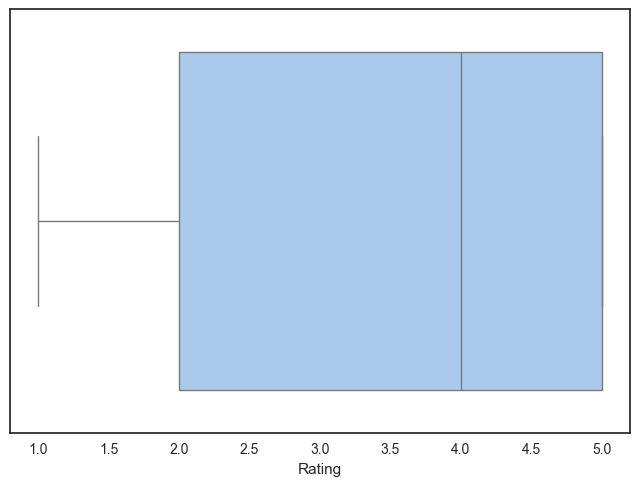

In [20]:
# Check the distribution of numerical features
sns.boxplot(x=model_df['Rating'])

## Bivariate Analysis

<Axes: xlabel='Person with Disability', ylabel='Rating'>

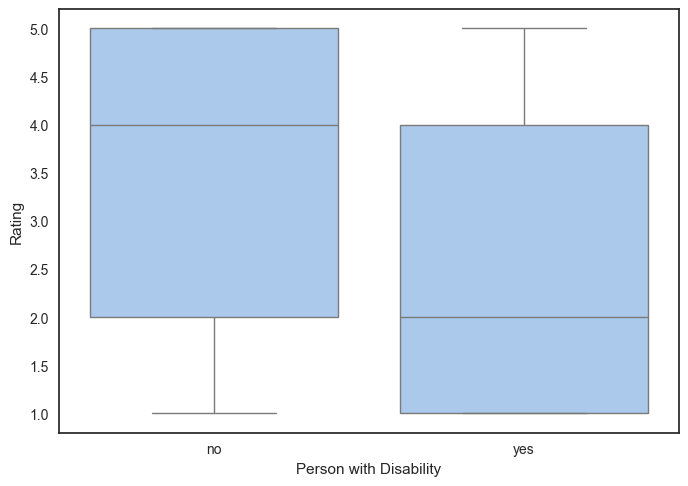

In [21]:
sns.boxplot(data=model_df, x="Person with Disability", y="Rating")

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [23]:
# sns.countplot(model_df, hue="Rating", x="Person with Disability")

In [24]:
# sns.countplot(model_df, hue="Rating", x="Access Frequency")

In [25]:
model_df.head()

,Location,Gender,Age,Access Frequency,Preferred Map Type,Person with Disability,Rating,Review
0,Toronto,M,25,daily,default-2d,no,5,Easy to use and very informative
1,Toronto,M,32,daily,default-2d,yes,2,Issues with handicap parking space availability
2,Montreal,F,61,monthly,default-2d,no,2,Map symbols complex
3,Winnipeg,F,42,weekly,default-2d,yes,5,I like it's simplicity in finding parking
4,Vancouver,M,61,weekly,default-2d,no,2,It is easy to use


In [26]:
#Drop Review
df_cs = model_df.drop(['Review'],axis=1)

In [27]:
df_cs.head()

,Location,Gender,Age,Access Frequency,Preferred Map Type,Person with Disability,Rating
0,Toronto,M,25,daily,default-2d,no,5
1,Toronto,M,32,daily,default-2d,yes,2
2,Montreal,F,61,monthly,default-2d,no,2
3,Winnipeg,F,42,weekly,default-2d,yes,5
4,Vancouver,M,61,weekly,default-2d,no,2


In [28]:
df_cs_info, cs_cat_feat, cs_num_feat = getDataSummary(df_cs)

In [29]:
cs_cat_feat, cs_num_feat

(['Location',
  'Gender',
  'Access Frequency',
  'Preferred Map Type',
  'Person with Disability'],
 ['Age', 'Rating'])

## Encode Categorical Features
- Label Encoding for frequency, Gender, Person with Disability
- One Hot Encoding for Location and Preferred Map Type

In [30]:
df_cs = df_cs
df_cs['Person with Disability'].replace( {'no': 0, 'yes': 1}, inplace=True)
df_cs.head(2)

,Location,Gender,Age,Access Frequency,Preferred Map Type,Person with Disability,Rating
0,Toronto,M,25,daily,default-2d,0,5
1,Toronto,M,32,daily,default-2d,1,2


In [31]:
df_cs['Gender'].replace( {'M': 0, 'F': 1}, inplace=True)
df_cs.head(2)

,Location,Gender,Age,Access Frequency,Preferred Map Type,Person with Disability,Rating
0,Toronto,0,25,daily,default-2d,0,5
1,Toronto,0,32,daily,default-2d,1,2


In [32]:
#Label Encoding the object dtypes.
# LE=LabelEncoder()
# model_data['Access Frequency']=model_data[['Access Frequency']].apply(LE.fit_transform)
# model_data.head()

df_cs['Access Frequency'].replace( {'daily': 0, 'weekly': 1, 'monthly':2}, inplace=True)
df_cs.head(2)

,Location,Gender,Age,Access Frequency,Preferred Map Type,Person with Disability,Rating
0,Toronto,0,25,0,default-2d,0,5
1,Toronto,0,32,0,default-2d,1,2


In [33]:
df_cs = pd.get_dummies(df_cs, columns=['Location','Preferred Map Type'], drop_first=False, dtype=int)
df_cs.head(2)

,Gender,Age,Access Frequency,Person with Disability,Rating,Location_Calgary,Location_Montreal,Location_Toronto,Location_Vancouver,Location_Winnipeg,Preferred Map Type_3d,Preferred Map Type_default-2d,Preferred Map Type_satellite,Preferred Map Type_terrain
0,0,25,0,0,5,0,0,1,0,0,0,1,0,0
1,0,32,0,1,2,0,0,1,0,0,0,1,0,0


Note All features ar enow numerical

In [34]:
df_cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Gender                         2936 non-null   int64
 1   Age                            2936 non-null   int64
 2   Access Frequency               2936 non-null   int64
 3   Person with Disability         2936 non-null   int64
 4   Rating                         2936 non-null   int64
 5   Location_Calgary               2936 non-null   int32
 6   Location_Montreal              2936 non-null   int32
 7   Location_Toronto               2936 non-null   int32
 8   Location_Vancouver             2936 non-null   int32
 9   Location_Winnipeg              2936 non-null   int32
 10  Preferred Map Type_3d          2936 non-null   int32
 11  Preferred Map Type_default-2d  2936 non-null   int32
 12  Preferred Map Type_satellite   2936 non-null   int32
 13  Preferred Map Type

## Standardization

In [35]:
scaler = StandardScaler()
scaler.fit(df_cs)

StandardScaler()

In [36]:
model_data_scaled =  scaler.fit_transform(df_cs)
model_data_scaled

array([[-0.69917366, -1.06486614, -0.97992255, ...,  0.77178506,
        -0.37855274, -0.2525235 ],
       [-0.69917366, -0.5522378 , -0.97992255, ...,  0.77178506,
        -0.37855274, -0.2525235 ],
       [ 1.43025982,  1.57150816,  1.3328207 , ...,  0.77178506,
        -0.37855274, -0.2525235 ],
       ...,
       [-0.69917366,  0.32655363, -0.97992255, ..., -1.29569754,
        -0.37855274, -0.2525235 ],
       [-0.69917366,  0.32655363, -0.97992255, ..., -1.29569754,
        -0.37855274, -0.2525235 ],
       [-0.69917366,  0.47301887, -0.97992255, ..., -1.29569754,
        -0.37855274, -0.2525235 ]])

In [37]:
model_data_scaled = pd.DataFrame(model_data_scaled, columns=df_cs.columns)
model_data_scaled.head(2)

,Gender,Age,Access Frequency,Person with Disability,Rating,Location_Calgary,Location_Montreal,Location_Toronto,Location_Vancouver,Location_Winnipeg,Preferred Map Type_3d,Preferred Map Type_default-2d,Preferred Map Type_satellite,Preferred Map Type_terrain
0,-0.699174,-1.064866,-0.979923,-0.701334,1.145625,-0.408573,-0.604633,1.328381,-0.433246,-0.273259,-0.48119,0.771785,-0.378553,-0.252523
1,-0.699174,-0.552238,-0.979923,1.425853,-0.777139,-0.408573,-0.604633,1.328381,-0.433246,-0.273259,-0.48119,0.771785,-0.378553,-0.252523


All features are now scaled

## Principal Component Analysis

In [38]:
pca = PCA(n_components=3)
pca.fit(model_data_scaled)
PCA_ds = pd.DataFrame(pca.transform(model_data_scaled), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2936.0,1.645671e-16,1.577349,-2.764717,-1.367745,-0.110927,1.454137,3.175628
col2,2936.0,6.988052e-17,1.345199,-2.178430,-0.959473,-0.017670,1.082034,3.217905
col3,2936.0,-6.292272e-17,1.274631,-2.084709,-1.064243,-0.052733,0.851117,3.605888


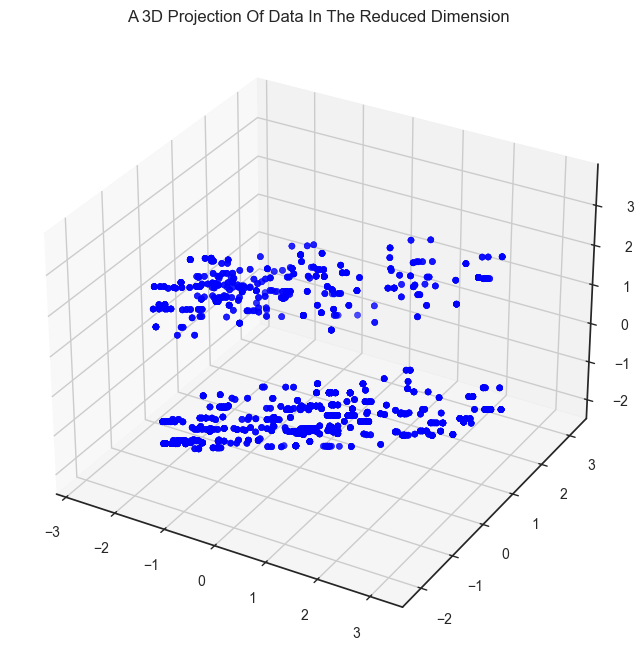

In [39]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="blue", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# K-Means Clustering

Elbow Method to determine the number of clusters to be formed:


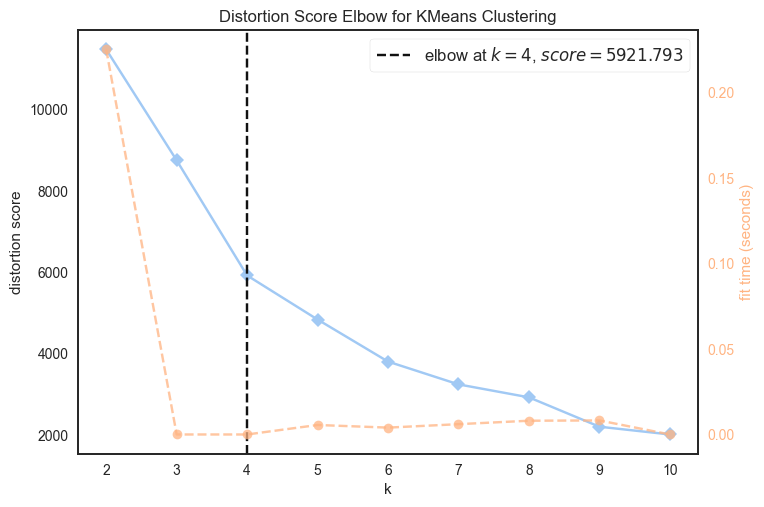

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [41]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df_cs["Clusters"]= yhat_AC

In [42]:
df_cs.head(20)

,Gender,Age,Access Frequency,Person with Disability,Rating,Location_Calgary,Location_Montreal,Location_Toronto,Location_Vancouver,Location_Winnipeg,Preferred Map Type_3d,Preferred Map Type_default-2d,Preferred Map Type_satellite,Preferred Map Type_terrain,Clusters
0,0,25,0,0,5,0,0,1,0,0,0,1,0,0,2
1,0,32,0,1,2,0,0,1,0,0,0,1,0,0,3
2,1,61,2,0,2,0,1,0,0,0,0,1,0,0,1
3,1,42,1,1,5,0,0,0,0,1,0,1,0,0,2
4,0,61,1,0,2,0,0,0,1,0,0,1,0,0,3
5,0,19,1,0,4,0,1,0,0,0,0,1,0,0,2
6,1,29,0,1,2,0,0,1,0,0,0,1,0,0,3
7,0,46,1,1,2,0,1,0,0,0,0,1,0,0,1
8,1,39,0,1,5,1,0,0,0,0,1,0,0,0,0
9,0,63,2,0,2,1,0,0,0,0,0,1,0,0,3


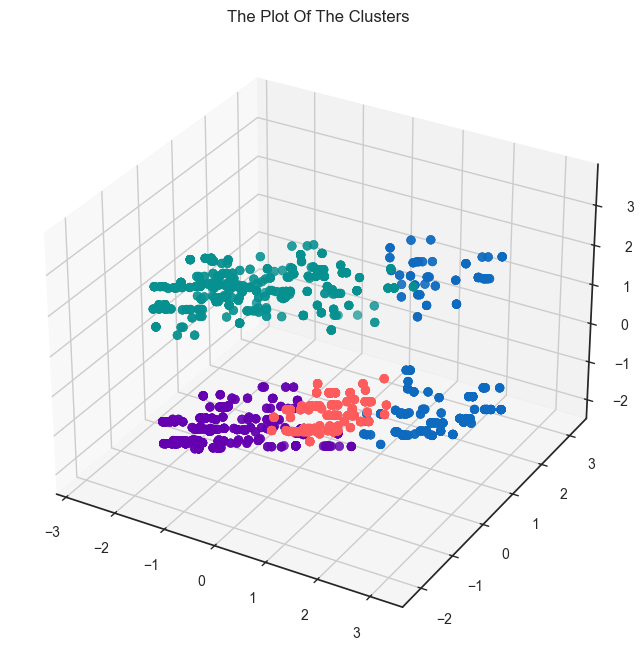

In [43]:
#Plotting the clusters
1
cmap = colors.ListedColormap(["#069090", "#0D6ABF", "#6500B0", "#FF5C5C"])
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

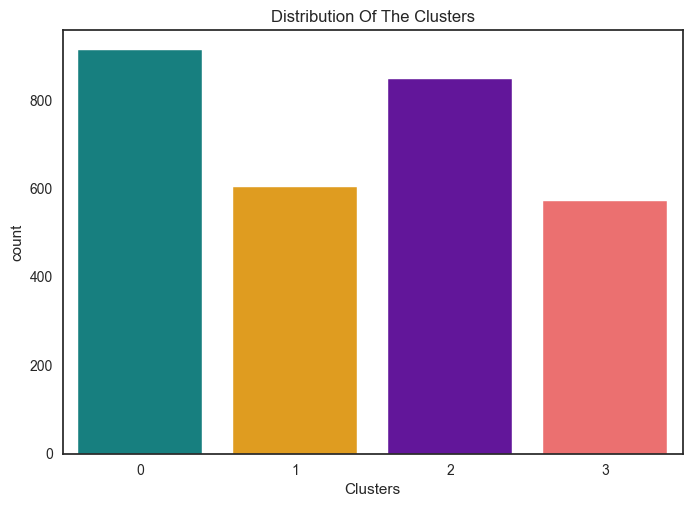

In [44]:
# Check clusters distribution
pal = ["#069090", "#FFA500", "#6500B0", "#FF5C5C"]
pl = sns.countplot(x=df_cs["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

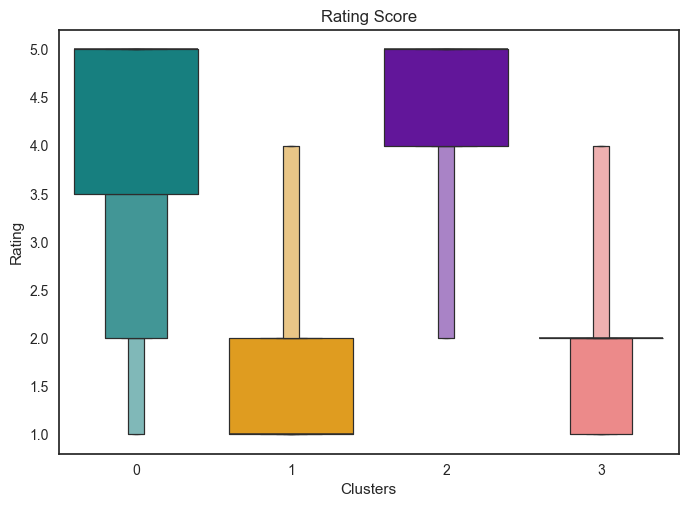

In [45]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df_cs["Rating"],x=df_cs["Clusters"], palette= pal)
pl.set_title("Rating Score")
plt.show()

In [46]:
df['Clusters'] = df_cs['Clusters']

In [47]:
# # Create a DataFrame with counts for each combination of Category and Group
# counts_df = df_cs.groupby(['Clusters', 'Person with Disability']).size().unstack(fill_value=0)

# # Create stacked bar chart
# counts_df_norm = counts_df.div(counts_df.sum(axis=1), axis=0)

# counts_df_norm.plot(kind='bar', stacked=True)
# plt.title('Stacked Bar Chart with Bivariate Analysis')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.legend(title='PWD', bbox_to_anchor=(1, 1))
# plt.show()

In [48]:
# # Create a DataFrame with counts for each combination of Category and Group
# counts_df = df_cs.groupby(['Clusters', 'Gender']).size().unstack(fill_value=0)

# # Create stacked bar chart
# counts_df_norm = counts_df.div(counts_df.sum(axis=1), axis=0)

# # Map encoded values to labels for the legend
# counts_df_norm.columns = counts_df_norm.columns.map(lambda x: 'Male' if x == 0 else 'Female')

# counts_df_norm.plot(kind='bar', stacked=True)
# plt.title('Stacked Bar Chart with Bivariate Analysis')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.legend(title='Gender', bbox_to_anchor=(1, 1))

# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy()
#     if height > 0.02:  # Adjust this threshold to show labels only for larger segments
#         ax.annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center', va='center')

# plt.show()


In [49]:
# # Create a DataFrame with counts for each combination of Category and Group
# counts_df = df_cs.groupby(['Clusters', 'Access Frequency']).size().unstack(fill_value=0)
# print(counts_df)
# # Create stacked bar chart
# counts_df_norm = counts_df.div(counts_df.sum(axis=1), axis=0)

# counts_df_norm.plot(kind='bar', stacked=True)
# plt.title('Stacked Bar Chart with Bivariate Analysis')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.legend(title='Access Frequency', bbox_to_anchor=(1, 1))
# plt.show()

In [50]:
# # Create a DataFrame with counts for each combination of Category and Group
# counts_df = df.groupby(['Clusters', 'Location']).size().unstack(fill_value=0)

# # Create stacked bar chart
# counts_df_norm = counts_df.div(counts_df.sum(axis=1), axis=0)

# counts_df_norm.plot(kind='bar', stacked=True)
# plt.title('Stacked Bar Chart with Bivariate Analysis')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.legend(title='Location', bbox_to_anchor=(1, 1))
# plt.show()

In [51]:
# Create age bins
bins = [10, 30, 40, 50, 60, 100]
labels = ['0-29', '30-39', '40-49', '50-59', '60+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

In [52]:


# # Create a DataFrame with counts for each combination of Category, Group, and AgeGroup
# counts_df = df.groupby(['Clusters', 'AgeGroup']).size().unstack(fill_value=0)
# # Create stacked bar chart
# counts_df_norm = counts_df.div(counts_df.sum(axis=1), axis=0)

# counts_df_norm.plot(kind='bar', stacked=True)
# plt.title('Stacked Bar Chart with Bivariate Analysis')
# plt.xlabel('Category')
# plt.ylabel('Count')
# plt.legend(title='Clusters', bbox_to_anchor=(1, 1))
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy()
#     if height > 0.02:  # Adjust this threshold to show labels only for larger segments
#         ax.annotate(f'{height:.0%}', (x + width/2, y + height/2), ha='center', va='center')

# plt.show()

In [53]:
# df_cluster1 = df.groupby(['Clusters', 'Location']).size().unstack(fill_value=0)
# df_cluster1.head(5)

In [54]:
# sns.countplot(df, hue=df["Clusters"], x=df["Person with Disability"], palette= pal)

# Analyzing Clusters

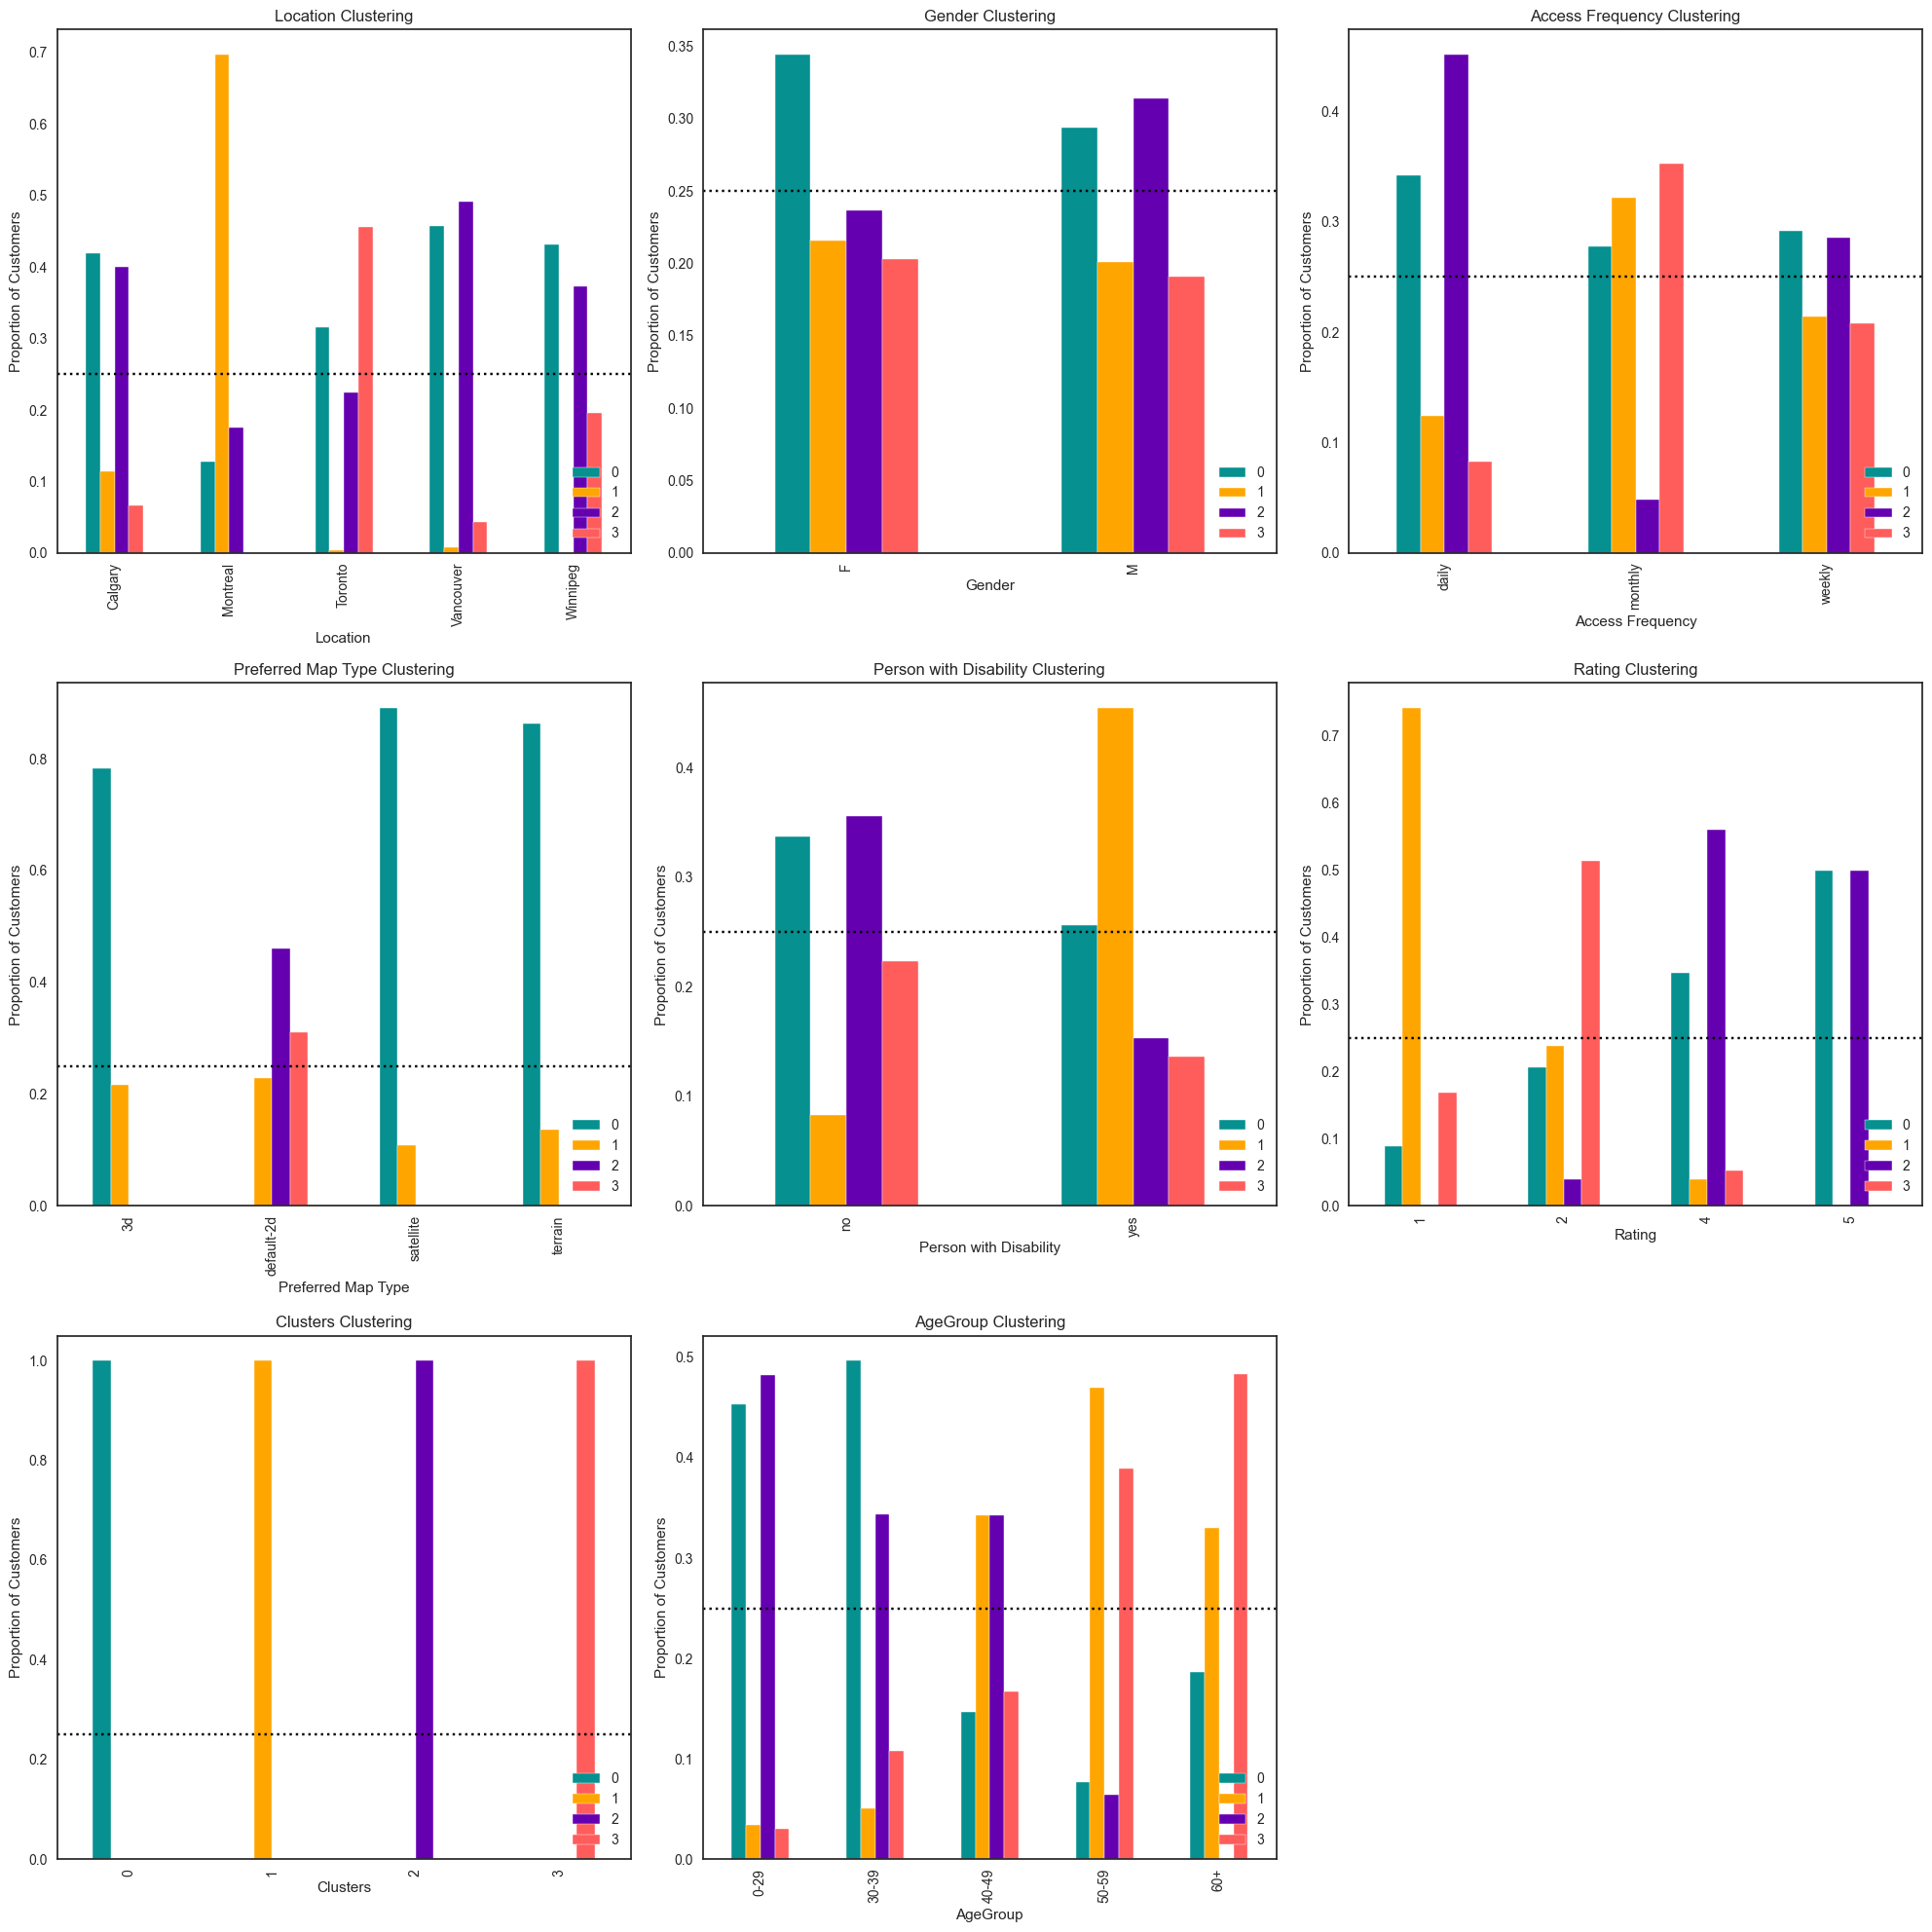

In [55]:
# Display stacked bar chart of categorical features
plt.figure(figsize = (20, 20))
plotnumber = 1

for feature in df:
    if feature not in ['Review', 'Age', 'Name', 'Customer ID']:
        x = df[feature]
        ax = plt.subplot(3,3,plotnumber)   
        table=pd.crosstab(df[feature],df['Clusters'])
        table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',ax=ax, stacked=False, color = pal).legend(loc='lower right')
        plt.title(f'{feature} Clustering')
        plt.ylabel('Proportion of Customers')
        plt.axhline(0.25, color='black', ls='dotted')  # Baseline: Overall attrition rate
        # plt.axhline(0.50, color='black', ls='dotted')  # Baseline: Overall attrition rate
        # plt.axhline(0.75, color='black', ls='dotted')  # Baseline: Overall attrition rate
        # plt.axhline(0.25, color='black', ls='dotted')  # Baseline: Overall attrition rate
        plotnumber += 1
    else:
        pass
plt.tight_layout()
plt.show()

In [56]:
df.drop(['AgeGroup'], axis=1, inplace=True)

In [57]:
df.columns

Index(['Customer ID', 'Name', 'Location', 'Gender', 'Age', 'Access Frequency',
       'Preferred Map Type', 'Person with Disability', 'Rating', 'Review',
       'Clusters'],
      dtype='object')

# Save Segmented Data

In [58]:
df.to_csv('v5_withCluster.csv', index=False)